In [78]:
import pandas as pd
from pyprojroot import here
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error

from nutils import name_mask, colordict

In [79]:
TARGET = 'occ'
FS = 'u'
CONTEXT = '12840'

In [80]:
true_matrix = pd.read_csv(
    here() / f'data/processed/true_matrices/{TARGET}.csv',
    index_col='datetime',
    parse_dates=True
)

In [81]:
def flatten(matrix):
    return matrix.values.flatten()

In [82]:
result_list = list()
error_list = list()
data_path = Path('data/processed/prediction_matrices/')

for p in here(data_path / '50').glob(f'*{FS}-{CONTEXT}.csv'):
    result = dict()
    
    parts = p.stem.split('-')
    
    result['Model'] = parts[1]
    result['FS'] = parts[2]
    name = parts[1] + '-' + parts[2]
    
    pred_matrix = pd.read_csv(
        p, 
        index_col='datetime', 
        parse_dates=True)
    
    idx = pred_matrix.dropna().index.intersection(true_matrix.dropna().index)

    pred_matrix = pred_matrix.loc[idx]
    true_matrix = true_matrix.loc[idx]
    
    true = true_matrix.groupby(true_matrix.index.month).apply(flatten).to_dict()
    pred = pred_matrix.groupby(pred_matrix.index.month).apply(flatten).to_dict()
    
    for month in range(1,13):
        rmse = mean_squared_error(true[month], pred[month], squared=False)
        result[month] = rmse
        
    result_list.append(result)

In [83]:
df = pd.DataFrame(result_list)

In [84]:
df['Mean'] = df.iloc[:,2:].mean(axis=1)
df = df.sort_values(by='Mean', ascending=False)
df = df.drop(columns='Mean')

In [85]:
df = df.set_index('Model')
df = df.drop(columns='FS')

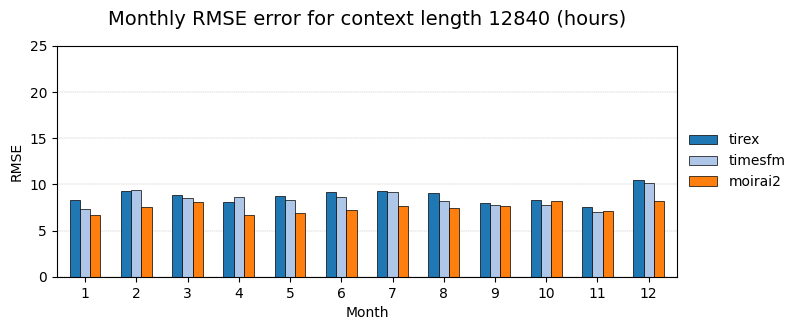

In [86]:
fig, ax = plt.subplots(figsize=(10,3))

# Add title with context length
ax.set_title(f"Monthly RMSE error for context length {CONTEXT} (hours)", fontsize=14, pad=15)

# Use a different color for each model (column) using a colormap
import matplotlib.pyplot as plt
import numpy as np

num_models = len(df.T.columns)
cmap = plt.get_cmap('tab20' if num_models <= 20 else 'tab20b')
colors = [cmap(i % cmap.N) for i in range(num_models)]

df.T.plot(kind='bar',
          edgecolor='k', 
          lw=.5,
          color=colors,
          ax=ax,
          width=.6)

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

ax.legend(frameon=False, 
          loc='center left', 
          bbox_to_anchor=(1, 0.5));

ax.set_ylabel('RMSE')
ax.set_xlabel('Month')
ax.set_ylim(top=25)
ax.set_axisbelow(True)
ax.grid(lw=.3, ls='--', axis='y')

plt.xticks(rotation=0)

plt.savefig(here() / f'output/plots/performance_monthly-{FS}-{CONTEXT}.jpg', 
            bbox_inches='tight',
            dpi=300)